# L02 Model creation and fine tunning

**Siamese neural networks**

Tell how similar two images are by comparing them in a model.Feed neural network with two images and then create an encoding of each images. The final result will be two vectors that will be compared.


## **Import libraries**

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available
print(torch.cuda.device_count())  # Number of GPUs available
print(torch.cuda.current_device())  # Current device index
print(torch.cuda.get_device_name(0))  # Name of GPU (if available)


True
1
0
NVIDIA GeForce RTX 3050 Laptop GPU


## 1. Load data

Using the provided set of pairs for the verification task, load and display a few a samples.

In [3]:
# Define folder for data.
DATASET = "./data/CompCars/data"
PAIR_FOLDER = os.path.join(DATASET, "train_test_split/verification")
PAIR_EASY = "verification_pairs_easy.txt"

# Load sets of pairs.
PAIRS_EASY = pd.read_csv(os.path.join(PAIR_FOLDER, PAIR_EASY),names = ["image1", "image2", "similarity"], sep = " ")


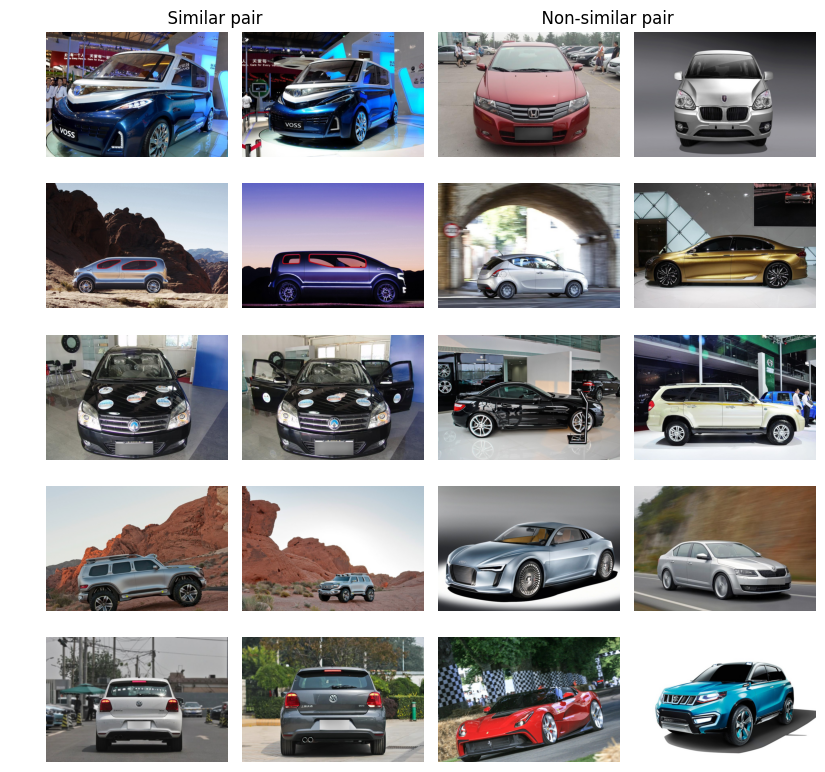

In [4]:
PATH_TO_IMAGE = os.path.join(DATASET, "image")
nonsimilar_pairs = PAIRS_EASY[PAIRS_EASY["similarity"] == 0]
similar_pairs = PAIRS_EASY[PAIRS_EASY["similarity"] == 1]

n_samples = 5
fig, axis = plt.subplots(n_samples, 4, figsize = (8,8))
axis[0,0].set_title("                              Similar pair")
axis[0,2].set_title("                              Non-similar pair")



for idx in range(n_samples):
    # Take a random number.
    r_number = np.random.randint(0, 10000)

    # Draw images with similarity 1
    image_1 = os.path.join(PATH_TO_IMAGE, similar_pairs["image1"].iloc[r_number])
    image_2 = os.path.join(PATH_TO_IMAGE, similar_pairs["image2"].iloc[r_number])
    axis[idx,0].imshow(cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB)), axis[idx,0].axis("off")
    axis[idx,1].imshow(cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB)), axis[idx,1].axis("off")


    # Draw images with similarity 0
    image_1n = os.path.join(PATH_TO_IMAGE, nonsimilar_pairs["image1"].iloc[r_number])
    image_2n = os.path.join(PATH_TO_IMAGE, nonsimilar_pairs["image2"].iloc[r_number])
    axis[idx,2].imshow(cv2.cvtColor(cv2.imread(image_1n), cv2.COLOR_BGR2RGB)), axis[idx,2].axis("off")
    axis[idx,3].imshow(cv2.cvtColor(cv2.imread(image_2n), cv2.COLOR_BGR2RGB)), axis[idx,3].axis("off")

plt.tight_layout()

In [30]:
def ResizeAndPad(image, target_size=(256, 256), padding_color=(0, 0, 0), resize=True):
    """
    Pads or resizes an image to a target size while maintaining its aspect ratio.
    
    Args:
        image (numpy.ndarray): Input image (H x W x C).
        target_size (tuple): Target size as (width, height).
        padding_color (tuple): Color of padding (default black) as (B, G, R).
        resize (bool): If True, resizes the image to fit within the target size before padding. 
                       If False, only adds padding to match the target size without resizing.
                       The target size must be greater than or equal to the original size if resizing is False.
    
    Returns:
        numpy.ndarray: Image padded or resized and padded to the target size.
    
    Notes:
        - The `INTER_AREA` interpolation method is used for resizing. It reduces aliasing effects while downsampling by averaging pixel values with respect to the overlapping area of the pixels.
    """
    target_width, target_height = target_size
    original_height, original_width = image.shape[:2]

    if not resize:
        if original_width > target_width or original_height > target_height:
            raise ValueError("Target size must be greater than or equal to the original size when resizing is disabled.")

        new_width, new_height = original_width, original_height
    else:
        # Calculate scaling factor to fit the image within the target size
        scale = min(target_width / original_width, target_height / original_height)
        new_width = max(int(original_width * scale), 1)
        new_height = max(int(original_height * scale), 1)

    if resize:
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    else:
        resized_image = image

    padded_image = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)

    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2

    padded_image[y_offset:y_offset+new_height, x_offset:x_offset+new_width] = resized_image

    return padded_image

# Convert image into Channel, height and width.
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
])


In [97]:
class SiameseDatasetLoader(Dataset):
    """
    Extract pairs of images path and label from a given .txt.

    Parameters:
        txt_file (str): path to txt.
        path (str): path to image folders.
        resizing (function): function that normalize image size applying zero padding.

    """
    
    # Init funtion that loads the txt and takes the paths and label.
    def __init__(self, txt_file, resizing = None, transform = None):

        self.pairs = []
        self.path = "data/CompCars/data/image"
        self.resizing = resizing 

        # Load data.
        self._load_txt_pairs(txt_file)


        
    def _load_txt_pairs(self, txt_file):
        """
        Load txt and extract paths and similarity label.
        """

        # Load txt.
        with open(txt_file, "r") as f:
            lines = f.readlines()

        for line in lines:
            # Remove blank spaces (strip) and separate strings (split).
            imp1, imp2, lbl = line.strip().split()
            # Save pairs into list.
            self.pairs.append((os.path.join(self.path,imp1), os.path.join(self.path,imp2), int(lbl)))
    
    def __len__(self):
        """
        Pytorch len function.
        """
        return len(self.pairs)
    

    def __getitem__(self, idx):
        """
        Read list with images paths and label and retrieve loaded images and label.
        """
        imp1, imp2, lbl = self.pairs[idx]

        # Load images.
        img1 = cv2.cvtColor(cv2.imread(imp1), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(imp2), cv2.COLOR_BGR2RGB)

        # Normalize images.
        #img1 = img1.astype(np.float32) / 255.0
        #img2 = img2.astype(np.float32) / 255.0

        # Pad images to get uniform size.
        if self.resizing:
            img1 = ResizeAndPad(img1)
            img2 = ResizeAndPad(img2)
        
        img1 = torch.tensor(img1, dtype=torch.float32).permute(2, 0, 1) / 255.0
        img2 = torch.tensor(img2, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        return img1, img2, torch.tensor(lbl, dtype=torch.float32)    

In [98]:
# Define path for easy samples.
easy_samples= os.path.join(PAIR_FOLDER, PAIR_EASY)

# Create dataset and apply resizing.
data_easy = SiameseDatasetLoader(txt_file = easy_samples, resizing=ResizeAndPad)
dataloader_easy = torch.utils.data.DataLoader(data_easy, batch_size = 32, shuffle = True)

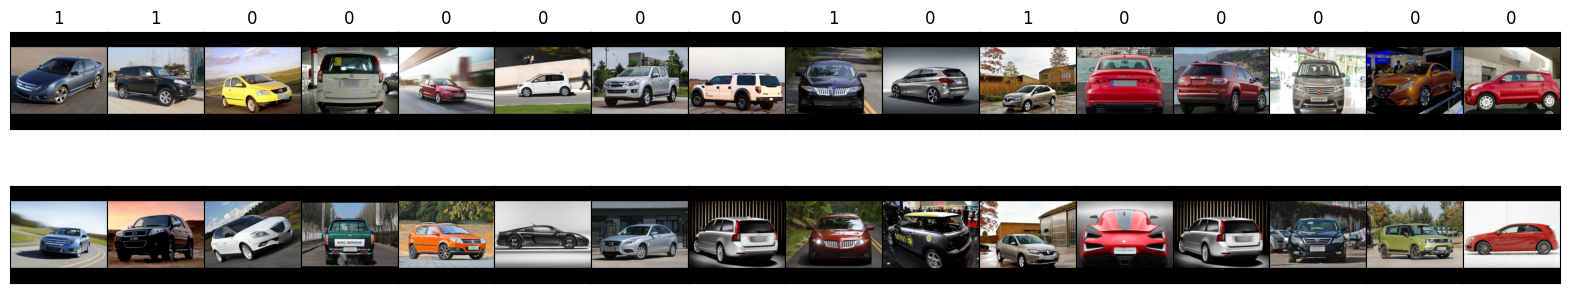

In [99]:
# Iterate over the dataloader and take a batch.
data_sample = next(iter(dataloader_easy))

fig, axis = plt.subplots(2, 16, figsize = (20, 4))

for idx in range(16):
    axis[0, idx].imshow(data_sample[0][idx].permute(1, 2, 0))
    axis[1, idx].imshow(data_sample[1][idx].permute(1, 2, 0))
    axis[0, idx].set_xticks([]), axis[0, idx].set_yticks([])  
    axis[1, idx].set_xticks([]), axis[1, idx].set_yticks([])
    axis[0, idx].set_title(str(int(data_sample[2][idx])))

plt.subplots_adjust(wspace=0, hspace=0)


## 2. Create models

### 2.1 Siamese Network

Neural Network Architecture capable of training pair of samples and analyzing how similar they are. Useful for verification tasks. Consists of two identical networks whose obtained encoded vectors are used for determining similarity. 

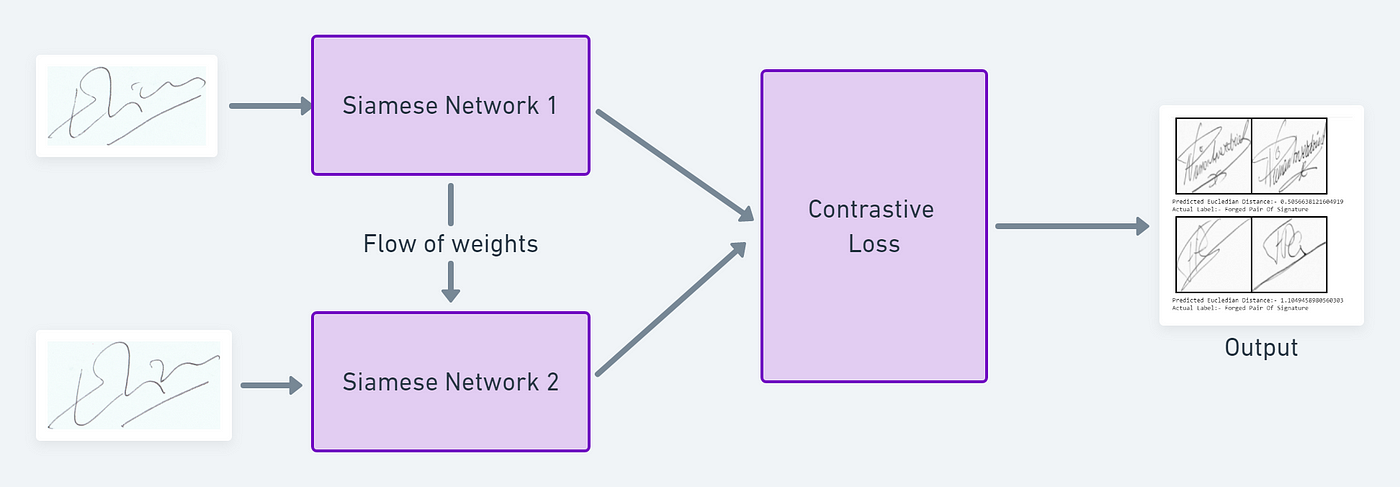

In [108]:
class SiameseNeuralNetwork(nn.Module):
    """
    Siamese Neural Network for performing image verification. Consists on 3 convolutional layers
    and 3 fully connected layers. Input and output shapes can be tune up.

    Parameters:
    number_channels (int): Number of channels of the input image.
    length_a (int): Number of channels for first convolutional layer.
    length_b (int): Number of channels for second convolutional layer.
    length_c (int): Number of channels for third convolutional layer.
    flatten_a (int): Number of neurons for the first fully connected layer.
    flatten_b (int): Number of neurons for the second fully connected layer.

    Method:
    forward_all(x): Computes feature vector for one sample.
    forward(input_a, input_b): Computes feature vector for two samples.
    """

    def __init__(self,number_channels, length_a, length_b, length_c, flatten_a, flatten_b, input_size = (256, 256)):
        super(SiameseNeuralNetwork, self).__init__()
        
        self.number_channels = number_channels
        self.input_size = input_size 

        # Create three convolutional layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(number_channels, length_a, kernel_size = 11, stride = 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
    
            nn.Conv2d(length_a, length_b, kernel_size = 5, stride = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        
            nn.Conv2d(length_b, length_c,  kernel_size = 3, stride = 1),
            nn.ReLU(inplace=True),
        )

        self.flattened_size = self._get_flatten_size(input_size)

        # Create two fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(self.flattened_size, flatten_a),
            nn.ReLU(inplace=True),
            nn.Linear(flatten_a, flatten_b),
            nn.ReLU(inplace=True),
            nn.Linear(flatten_b, 2)
        )
    
    def forward_all(self, x):
        """
        Pass image tensor through convolutional and fully connected layer.

        Parameters:
        x (tensor) -> image tensor from dataset.

        Output:
        output (array) -> encoded vector.
        """
        output = self.cnn1(x)
        # Take batch dimension and multiply the rest.
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input_a, input_b):
        """
        Main forward function that passes two images in the Siamese Network
        for computing encoding vectors.

        Parameters:
        input_a (tensor) -> image tensor from dataset.
        input_b (tensor) -> image tensor from dataset.

        Output:
        output1 (array) -> encoded vector.
        output2 (array) -> encoded vector.
        """
        output1 = self.forward_all(input_a)
        output2 = self.forward_all(input_b)

        return output1, output2

    def _get_flatten_size(self, input_size):
        """Helper function to compute the flattened size dynamically"""
        # Create input tensor.
        dummy_input = torch.zeros(3, self.input_size[0], self.input_size[1])
        
        # Forward it into convolutional network and retrieve final size
        output = self.cnn1(dummy_input.unsqueeze(0))
        return output.view(1, -1).size(1)


### 2.2 Contrastive Loss

Used to learn embeddings that gets similar pairs closer and separates dissimilar pairs. 


The contrastive loss is defined as:

$$
\left ( 1-Y \right )\left ( \frac{1}{2} \right )\left ( D_{W} \right )^{2} +\left ( Y \right )\frac{1}{2}\left\{max\left ( 0,m-D_{W} \right ) \right\}^{2}
$$

Where:
- Y: Label saying if the pairs are similar.
- D: Euclidean distance between two encoded vectors.
- m: Margin that defines minimum distance for dissimilar pairs.

In [109]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss function to compute how similar are a pair of encoded vectors.


    """
    def __init__(self, margin = 2.6):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output_a, output_b, label):
        """
        Contrastive loss function.

        Args:
            output_a (tensor): encoded vector for image a.
            output_b (tensor): encoded vector for image b.
            label (int): similarity label, 0 if it's similar, 1 if it's not.

        Output:
            loss_contrastive (float): loss
        """
        euclidean_distance = F.pairwise_distance(output_a, output_b, keepdim=True)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

### 2.3 Triplet loss

The triplet loss is defined as:

$$
\mathcal{L} = \sum_{i=1}^N \left[ \| f(x_a^i) - f(x_p^i) \|_2^2 - \| f(x_a^i) - f(x_n^i) \|_2^2 + \alpha \right]_+
$$

In [110]:
class TripletLoss(nn.Module):
    """
    Triplet Loss function to ensure the anchor is closer to the positive than to the negative.
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Compute Triplet Loss.

        Args:
            anchor (torch.Tensor): Encoded vector for the anchor.
            positive (torch.Tensor): Encoded vector for the positive sample.
            negative (torch.Tensor): Encoded vector for the negative sample.

        Returns:
            torch.Tensor: Triplet loss value.
        """

        positive_distance = F.pairwise_distance(anchor, positive)  # Distance between anchor and positive
        negative_distance = F.pairwise_distance(anchor, negative)  # Distance between anchor and negative

        loss = torch.mean(torch.clamp(positive_distance - negative_distance + self.margin, min=0.0))
        return loss


### 2.4 Training function

In [135]:
def compute_accuracy(output1, output2, label, margin=1.0):

    # Compute the Euclidean distance between the embeddings
    euclidean_distance = F.pairwise_distance(output1, output2, p=2)
    
    # Predict similar or dissimilar based on distance threshold (margin)
    predicted_labels = (euclidean_distance < margin).float()
    
    # Compute the number of correct predictions
    correct_predictions = (predicted_labels == label).sum().item()
    
    # Calculate accuracy
    accuracy = correct_predictions / label.size(0)
    
    return accuracy

In [134]:
def training_model_with_accuracy(data, model, loss, optimizer, epochs, margin=1.0):

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model in GPU
    model = model.to(device)
    loss_vals = []
    acc_vals = []

    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0
        total_accuracy = 0.0
        total_samples = 0

        # Iterate over batches in the dataset
        for img1, img2, labels in tqdm(data, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            
            # Move data to GPU
            img1, img2, labels = img1.float().to(device), img2.float().to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            output1, output2 = model(img1, img2)  # Forward pass
            loss_val = loss(output1, output2, labels)  # Compute loss
            loss_val.backward()  # Backpropagate gradients
            optimizer.step()  # Update weights

            running_loss += loss_val.item()

            # Compute accuracy for this batch
            accuracy = compute_accuracy(output1, output2, labels, margin)
            total_accuracy += accuracy * labels.size(0)
            total_samples += labels.size(0)

        avg_loss = running_loss / len(data)
        avg_accuracy = total_accuracy / total_samples

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
        loss_vals.append(avg_loss)
        acc_vals.append(avg_accuracy)

    return model, loss_vals, acc_vals


## 3. Training models

### 3.1 Vainilla training

In [136]:
### INITIAL PARAMETERS ###
SAMPLES = os.path.join(PAIR_FOLDER, PAIR_EASY)
BATCH_SIZE = 64
L_RATE = 0.001
MARGIN = 1.0
EPOCHS = 100

# Set up DataLoader.
data_easy = SiameseDatasetLoader(txt_file = SAMPLES, resizing=ResizeAndPad)
dataloader = torch.utils.data.DataLoader(data_easy, batch_size=BATCH_SIZE, shuffle=True)

# Extract input size.
shape_sample = next(iter(dataloader_easy))[0].shape[2:]

# Define model configuration.
model_vanilla = SiameseNeuralNetwork(number_channels=3, length_a=6, length_b=9,
                              length_c=12, flatten_a=15, flatten_b=10,
                              input_size = shape_sample)

# Define loss and optimizer.
criterion = ContrastiveLoss(margin=MARGIN)
optimizer = optim.Adam(model_vanilla.parameters(), lr=L_RATE)


In [137]:
#vanilla_model = training_model(dataloader, model_vanilla, criterion, optimizer, EPOCHS)